In [3]:
#imports
import matplotlib.pyplot as plt
import scipy
import astropy.io
from astropy.io import fits
from astropy import wcs
import numpy as np
from numpy import append
import healpy as hp
from cosmology import *
from scipy.interpolate import *
import pixell
from pixell import reproject, enplot, enmap, utils
import tarfile
import orphics
from orphics import catalogs

In [ ]:
# loads Planck map
# get magnitude and direction of gradient from this map
# low res so don't stack with this 

plc_map = hp.read_map('PLA_data.fits')
# reproject the Planck map (healpix -> CAR)
fshape, fwcs = enmap.fullsky_geometry(res= 0.5 * utils.arcmin, proj="car")
plc_map = plc_map.astype(np.float64)
pmap = reproject.healpix2map(plc_map, fshape, fwcs, lmax=6000, rot="gal,equ")

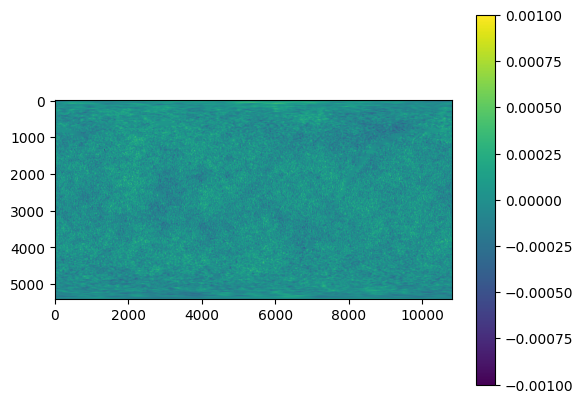

In [27]:
# DONT RERUN

plt.imshow(pmap, vmin = -.001, vmax = .001)
plt.colorbar()

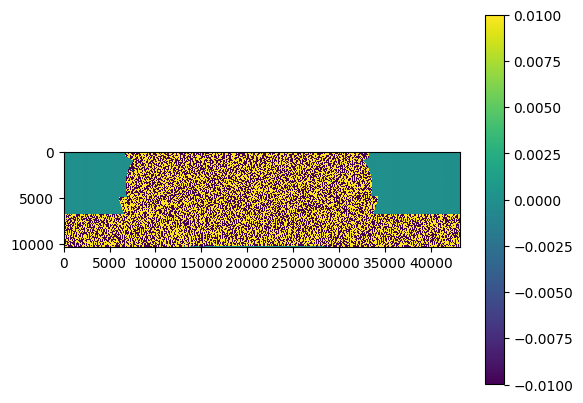

In [115]:
#DONT RERUN

plt.imshow(ACTmap, vmin = -.01, vmax = .01)
plt.colorbar()

In [2]:
# Loads catalog of real halo data

def load_fits(fits_file,column_names,hdu_num=1,Nmax=None):
    hdu = fits.open(fits_file)
    columns = {}
    for col in column_names:
        columns[col] = hdu[hdu_num].data[col][:Nmax]
    hdu.close()
    return columns

In [29]:
# Loads catalog of real halo data

column_names = 'RADeg', 'decDeg', 'SNR'
halo = '/home1/mathm/act/hiltonm/cluster_candidates/dr6-3freq-multipass-20220404/dr6-3freq-multipass_optimalCatalog.fits'
funct = load_fits(halo, column_names, hdu_num=1,Nmax=None)
RA_array = funct['RADeg']
dec_array = funct['decDeg']
SNR_array = funct['SNR']

In [1]:
# selects coordinates with SNR greater than 5

def SNR_selection(column):
    return column[np.greater(SNR_array, 5)]

In [78]:
# creates lists of selected coordinates

RA_selected = SNR_selection(RA_array)
dec_selected = SNR_selection(dec_array)
SNR_selected = SNR_selection(SNR_array)

In [82]:
# gives halo coordinates
# NOTE THESE ARE IN DEGREES DOES THAT MATTER?

def read_halo(i):
    return dec_selected[i], RA_selected[i]

In [298]:
# get galaxy thumbnails from planck map

# Creates thumbnail around selected coordinates
def thumbnail(i, coord_list, enmap, size):
    coords = coord_list(i)
    return reproject.thumbnails(enmap, np.deg2rad(coords), r = size*utils.arcmin)

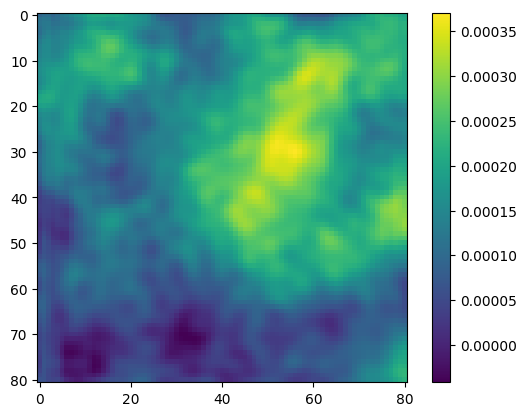

In [299]:
plt.imshow(thumbnail(1, read_halo, pmap, 40))
plt.colorbar()

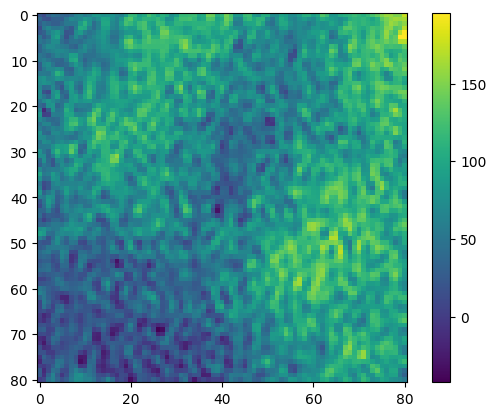

In [300]:
plt.imshow(thumbnail(1, read_halo, ACTmap,10))
plt.colorbar()

In [301]:
# Calculates the magnitude of the average gradient of a thumbnail
def gradient(i, coord_list):
    y_grad, x_grad = np.gradient(thumbnail(i, coord_list, pmap, size = 40))
    x_ave = np.mean(x_grad)
    y_ave = np.mean(y_grad)
    mag = np.sqrt(x_ave**2 + y_ave**2) * 10**6
    angle = np.arctan2(y_ave,x_ave)
    return mag, angle

In [208]:
# Loads ACT map, higher resolution for stacking

ACT = '/home1/mathm/act/sigurdkn/coadds/dr6v3/act_daynight_f150_map_srcfree.fits'
amap = enmap.read_map(ACT)[0]
ACTmap = amap.astype(np.float64)

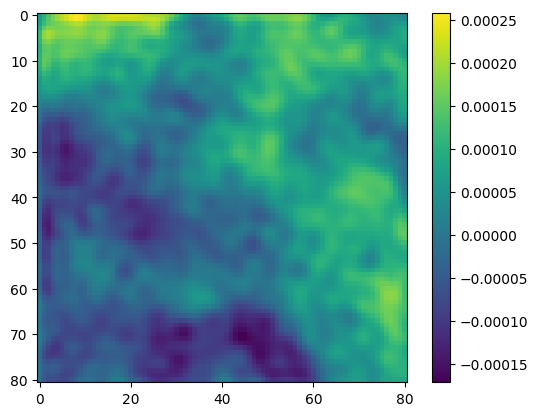

In [303]:
image = thumbnail(0, read_halo, pmap, 40)
plt.imshow(image)
plt.colorbar()

In [304]:
# Rotates selected thumbnail
def rotate_thumbnail(i, coord_list, enmap, size):
    rad_angle = gradient(i, coord_list)[1]
    return scipy.ndimage.rotate(thumbnail(i, coord_list, enmap, size), np.rad2deg(rad_angle), reshape = False, mode='constant', cval=np.nan)

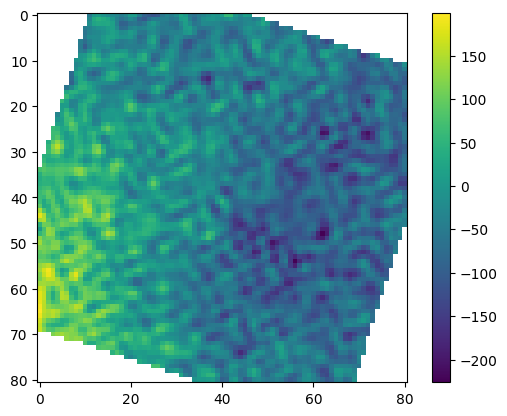

In [323]:
image = rotate_thumbnail(0, read_random, ACTmap,10)
plt.imshow(image)
plt.colorbar()

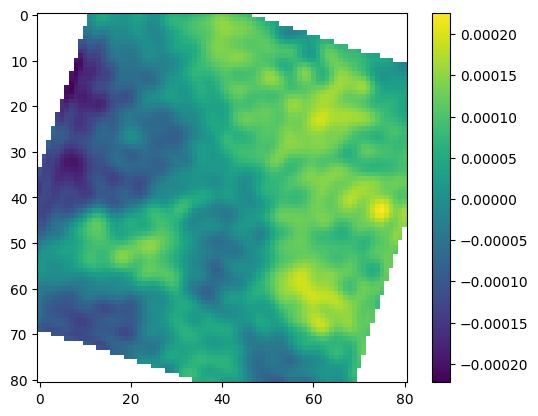

In [324]:
image = rotate_thumbnail(0, read_random, pmap, 40)
plt.imshow(image)
plt.colorbar()

In [307]:
# Stacks rotated thumbnails
def averaged_map_rotated(n, coord_list):
    image_list_rotated = []
    gradient_array = []
    #add rotated thumbnails to an array
    for i in range(n):
        grad = gradient(i, coord_list)[0]
        # multiplies rotated thumbnail by the magnitude of its gradient
        stamp = rotate_thumbnail(i, coord_list, ACTmap, 10) * grad
        image_list_rotated.append(stamp)
        gradient_array.append(grad)
    # Stack the images into a single NumPy array
    stacked_images_rotated = np.stack(image_list_rotated, axis = 0)
    # Compute the weighted average of the stacked thumbnails
    return np.average(stacked_images_rotated, axis = 0, weights= gradient_array)

In [213]:
print(len(dec_selected))

6191


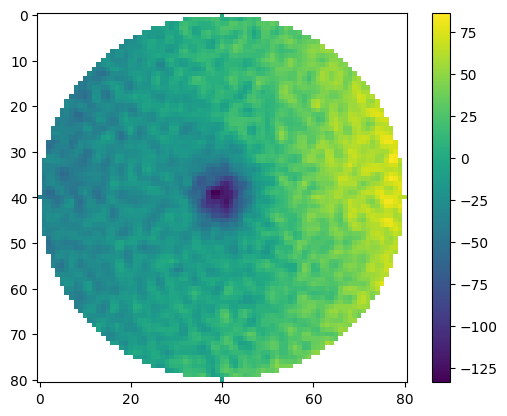

In [308]:
plt.imshow(averaged_map_rotated(100, read_halo))
plt.colorbar()

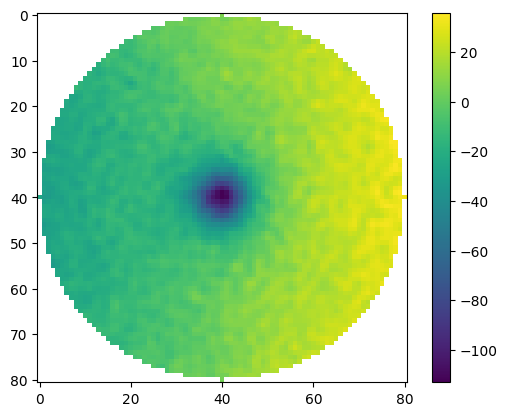

In [309]:
plt.imshow(averaged_map_rotated(1000, read_halo))
plt.colorbar()

In [310]:
# Creates coordinates for random locations in the lensed CMB map
# NOTE THESE ARE IN RADIANS DOES THAT MATTER

np.random.seed(2)

lower_dec = 0  # Lower bound (inclusive)
upper_dec = np.pi  # Upper bound (exclusive)

# Generate an array of random numbers for theta
random_dec = np.random.uniform(lower_dec, upper_dec, size=(len(dec_selected),))

lower_RA = 0  # Lower bound (inclusive)
upper_RA = 2*np.pi  # Upper bound (exclusive)

# Generate an array of random numbers for phi
random_RA = np.random.uniform(lower_RA, upper_RA, size=(len(dec_selected),))

In [311]:
# Converts random coordinates to latitude and longitude
def read_random(i):
    return random_dec[i], random_RA[i]

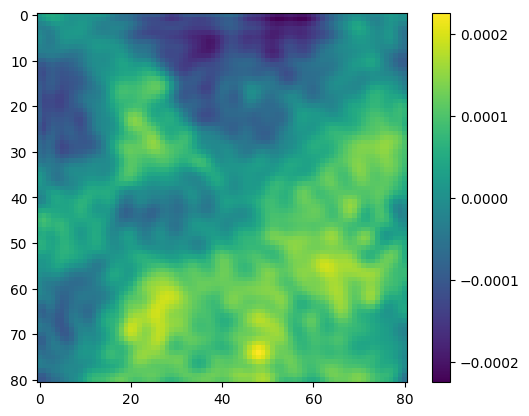

In [316]:
plt.imshow(thumbnail(0, read_random, pmap, 40))
plt.colorbar()

In [ ]:
# # Calculates the magnitude of the average gradient of a thumbnail
# def gradient_random(i, coord_list, enmap):
#     y_grad, x_grad = np.gradient(thumbnail(i, coord_list, enmap))
#     x_ave = np.mean(x_grad)
#     y_ave = np.mean(y_grad)
#     mag = np.sqrt(x_ave**2 + y_ave**2) * 1*10**6
#     angle = np.arctan2(y_ave,x_ave)
#     return mag, angle

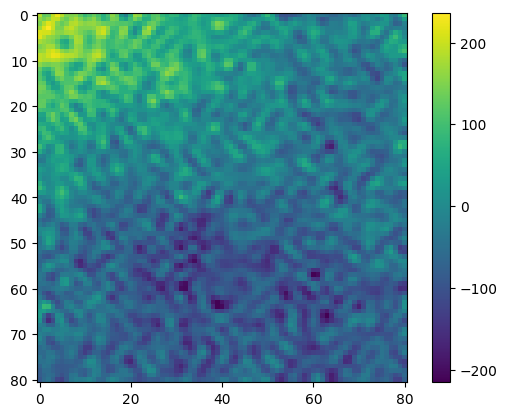

In [317]:
plt.imshow(thumbnail(0, read_random, ACTmap, 10))
plt.colorbar()

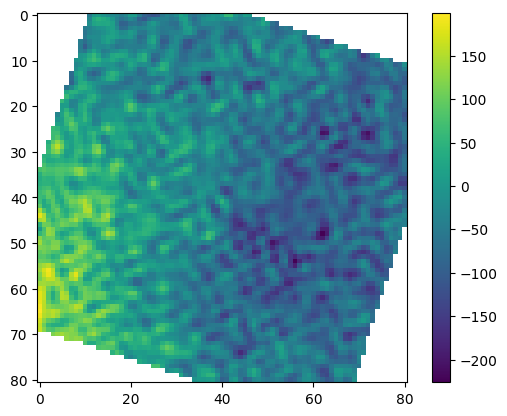

In [318]:
plt.imshow(rotate_thumbnail(0, read_random, ACTmap, 10))
plt.colorbar()

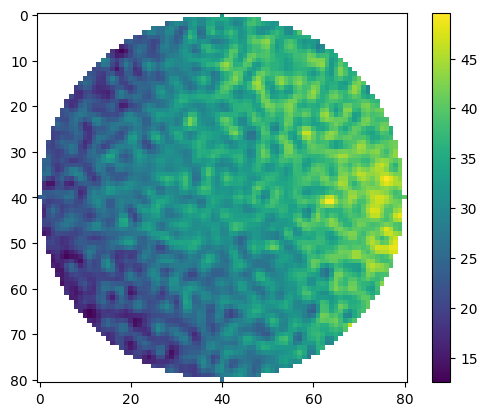

In [325]:
plt.imshow(averaged_map_rotated(1000, read_random))
plt.colorbar()

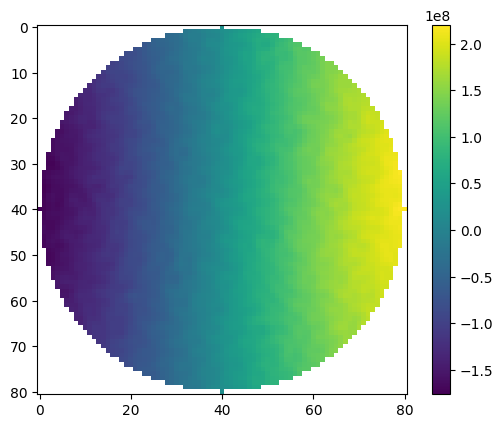

In [237]:
plt.imshow(averaged_map_rotated(1000, read_random, ACTmap))
plt.colorbar()

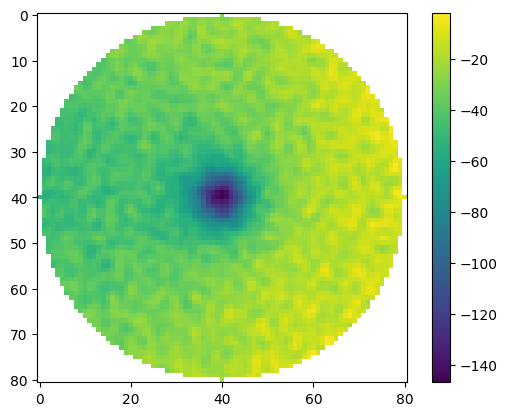

In [326]:
plt.imshow(averaged_map_rotated(1000, read_halo) - averaged_map_rotated(1000, read_random))
plt.colorbar()

# WoRKSHOP

In [46]:
ACTmap.dtype

dtype('float64')

In [47]:
pmap.dtype

dtype('float64')

In [31]:
ACTmap.shape

(10320, 43200)

In [32]:
pmap.shape

(5401, 10800)

In [35]:
reproject_thumbnail(1, read_halo, pmap).shape

(21, 21)

In [49]:
thumbnail(2, read_halo, ACTmap).shape

KeyboardInterrupt: 

In [29]:
a = thumbnail(2, read_halo, ACTmap)
print(a.shape)
print(a.dtype)

(81, 81)
float32


In [28]:
plt.imshow(thumbnail(2, read_halo, ACTmap))
plt.colorbar()

KeyboardInterrupt: 